<a href="https://colab.research.google.com/github/lebatt11/kaggle-/blob/main/modelonWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Importation des bibliothéques nécessaires :

In [3]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from PIL import Image as mpimg
import matplotlib.image as mpimg
drive.mount('/content/drive')
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Mounted at /content/drive


# 2- Exploration des données :

# 2.1 Construction du chemin vers les répertoires du projet  :

In [4]:
cwd = os.getcwd()
main_file_path = os.path.join(cwd, 'model.ipynb')


colab_notebooks_path = '/content/drive/My Drive/Colab Notebooks'


input_path = '/content/drive/My Drive/chest_xray'

train_path = os.path.join(input_path, 'train')
test_path = os.path.join(input_path, 'test')
val_path = os.path.join(input_path, 'val')

# 2.2 Visualisation de quelques images de l'ensemble de données :

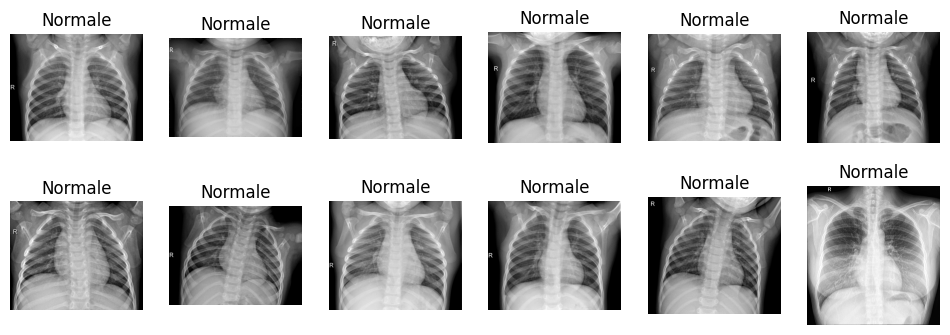

In [5]:
import os
import matplotlib.pyplot as plt

input_path = '/content/drive/My Drive/chest_xray'

nows = 2
ncols = 6

train_path = input_path + '/train/NORMAL'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Normale")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()


# 2.3 Visualisation de quelques images anormales de l'ensemble de données :

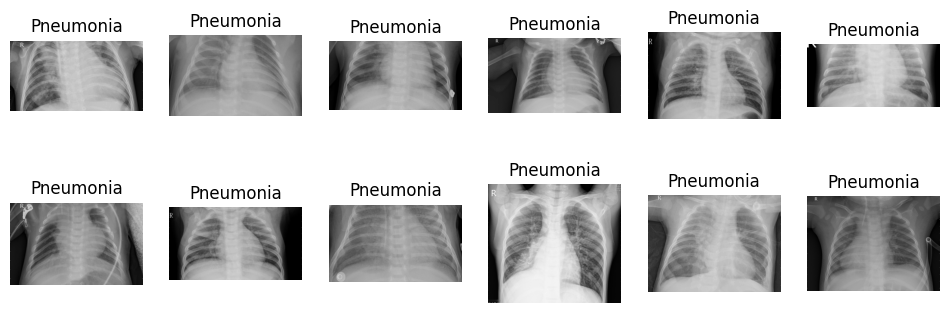

In [6]:
nows = 2
ncols = 6

train_path = input_path + '/train/PNEUMONIA'


files = os.listdir(train_path)
rand_images = random.sample(files,nows*ncols)

fig = plt.gcf()
fig.set_size_inches(ncols*2, nows*2)


for i in range(len(rand_images)):
    sp = plt.subplot(nows, ncols, i + 1)
    plt.title("Pneumonia")
    sp.axis('Off')

    img = mpimg.imread(train_path + '/' + rand_images[i])
    plt.imshow(img,cmap='gray')

plt.show()

# 2.4- Voir les informations sur les répertoires :

In [7]:
print("Le nombre d'images normales dans le répertoire train : ",len(os.listdir(input_path + "/train/NORMAL")))
print("Le nombre d'images anormales dans le répertoire train : ", len(os.listdir(input_path + "/train/PNEUMONIA")))

print("le nombre d'images normales dans le répertoire test : ",len(os.listdir(input_path + "/test/NORMAL")))
print("Le nombre d’images anormales dans le répertoire test : ",len(os.listdir(input_path + "/test/PNEUMONIA")))

print("Le nombre d'images normales dans le répertoire val : ",len(os.listdir(input_path + "/val/NORMAL")))
print("Le nombre d’images anormales dans le répertoire val : ",len(os.listdir(input_path + "/val/PNEUMONIA")))

Le nombre d'images normales dans le répertoire train :  1341
Le nombre d'images anormales dans le répertoire train :  3875
le nombre d'images normales dans le répertoire test :  234
Le nombre d’images anormales dans le répertoire test :  390
Le nombre d'images normales dans le répertoire val :  8
Le nombre d’images anormales dans le répertoire val :  8


# 3- prétraitement des données :

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_data(input_path, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_path = os.path.join(input_path, 'train')
    test_path = os.path.join(input_path, 'test')

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_gen = test_val_datagen.flow_from_directory(
        test_path,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['NORMAL', 'PNEUMONIA']:
        for img in os.listdir(os.path.join(test_path, cond)):
            img = plt.imread(os.path.join(test_path, cond, img))
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == 'NORMAL':
                label = 0
            elif cond == 'PNEUMONIA':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

# Chemins complets des répertoires
input_path = '/content/drive/My Drive/chest_xray'

img_dims = 150
batch_size = 32
epochs = 10
train_gen, test_gen, test_data, test_labels = process_data(input_path, img_dims, batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 4- choix d'une architecture de réseau neuronal

In [19]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Viewing model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 75, 75, 32)        688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 75, 75, 32)        1344  

# 4.1- Gestion des callbacks pendant l'entraînement du modèle

In [20]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# 5- Entrainement du modéle :

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-9-1556081dfae9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
163/163 [==============================] - 132s 808ms/step - loss: 0.1212 - accuracy: 0.9561 - val_loss: 0.2844 - val_accuracy: 0.9062 - lr: 2.7000e-05
Epoch 2/10
163/163 [==============================] - 129s 791ms/step - loss: 0.1205 - accuracy: 0.9569 - val_loss: 0.2548 - val_accuracy: 0.9145 - lr: 2.7000e-05
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9555
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
163/163 [==============================] - 131s 804ms/step - loss: 0.1273 - accuracy: 0.9555 - val_loss: 0.2384 - val_accuracy: 0.9211 - lr: 2.7000e-05
Epoch 4/10
163/163 [==============================] - 138s 843ms/step - loss: 0.1147 - accuracy: 0.9624 - val_loss: 0.2410 - val_accuracy: 0.9178 - lr: 8.1000e-06
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9586
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
163/163 [======

# 6- évaluation du modéle sur l'ensemble de test(données non vues)

In [ ]:
# Charger les données de test (remplacez cela par votre propre logique de chargement de données)
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

# Charger les poids optimaux
model.load_weights('best_weights.hdf5')

# Évaluation sur l'ensemble de test
evaluation = model.evaluate(test_data, test_labels)

# Afficher les résultats de l'évaluation
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
20/20 [==============================] - 2s 101ms/step - loss: 0.1992 - accuracy: 0.9279
Loss: 0.19920243322849274
Accuracy: 0.9278846383094788


# 7- Visualisation des résultats :

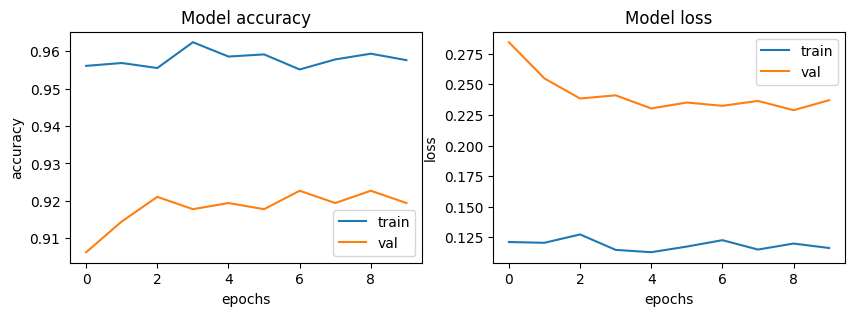

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 8- Prédiction et calcul de la précision, rappel et F1-score :

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)




acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()


precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

20/20 [==============================] - 2s 107ms/step
Accuracy: 92.78846153846155%
Precision: 91.76755447941889%
Recall: 97.17948717948718%
F1-score: 94.39601494396015

TRAIN METRIC ----------------------
Train acc: 95.76


# 9- création de la matrice de confusion :

20/20 [==============================] - 9s 437ms/step


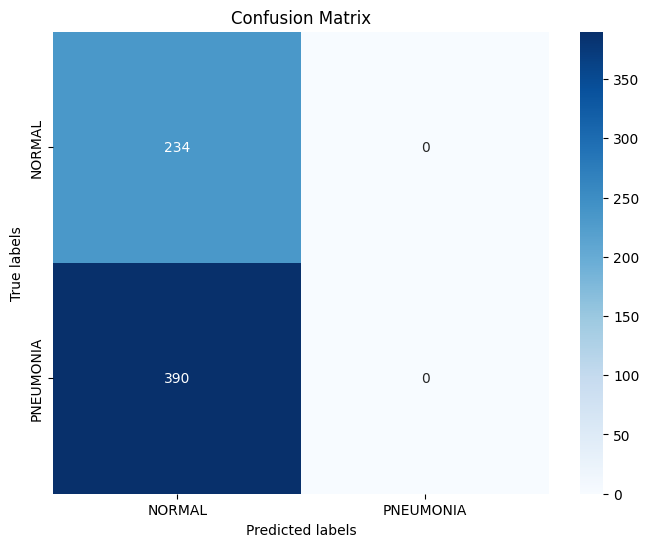

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(test_gen)

# Convertir les prédictions en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int)

# Obtenir les étiquettes réelles
true_classes = test_gen.classes

# Obtenir les noms des classes
class_labels = list(test_gen.class_indices.keys())

# Créer la matrice de confusion
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



# 10- Sauvegarde du modéle :

In [ ]:
# Définir le chemin de sauvegarde du modèle
model_save_path = '/content/drive/My Drive/pneumonia_model.h5'

# Sauvegarder le modèle
model.save(model_save_path)

print("Le modèle a été sauvegardé avec succès à l'emplacement :", model_save_path)


Le modèle a été sauvegardé avec succès à l'emplacement : /content/drive/My Drive/pneumonia_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
